In [1]:
using Pkg
Pkg.activate("E:\\Pythonfiles\\JP\\ML\\Project.toml")
using DifferentialEquations
using LinearAlgebra, DiffEqSensitivity, Optim
using Flux: flatten, params
using DiffEqFlux, Flux
using Plots
using Flux: train!
using NNlib

  Activating environment at `E:\Pythonfiles\JP\ML\Project.toml`


# Explore Why we need neural differential equations

# 1. Simple Model

In this part, I will use different methods to learn the data generated by the following differential equation:
$$u'(t) = f(u) :=0.2u\exp(-0.2u)(1-u/2)+0.2 sin(u)$$



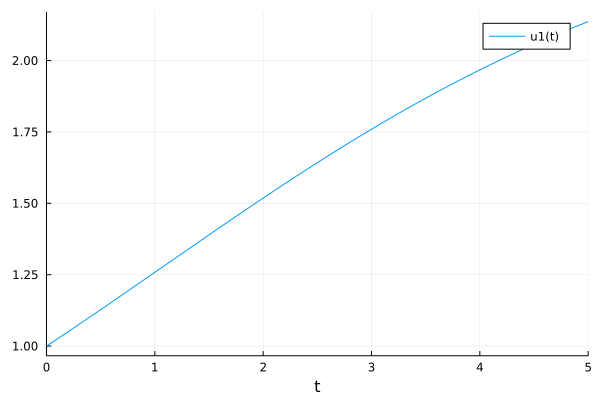

1×101 Matrix{Float64}:
 1.0  1.02513  1.05047  1.076  1.1017  …  2.52359  2.52715  2.53058  2.53391

In [2]:
# data generation
function model(du,u,p,t)
    r, α = p
   du .= r.*u.*exp.(-r.*u).*(1 .- u./α) + r.* sin.(u)
end
u_0 = [1.0]
p_data = [0.2,2]
tspan_data = (0.0, 5)
prob_data_1 = ODEProblem(model,u_0,tspan_data,p_data)
data_solve = solve(prob_data_1, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)
data_withoutnois = Array(data_solve)
data = data_withoutnois
display(plot(data_solve))

tspan_predict = (0.0, 10.0)
prob_predict = ODEProblem(model,u_0,tspan_predict,p_data)
test_data = solve(prob_predict, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)
data_real = Array(test_data)

## 1.1. using NN(t) to learn the data 


0.5615870135013131
0.06443773562906276
0.006626621177301438
0.0005076237048399401
0.000197685714917459


0.00018864653761878312
0.0001850651574196976
0.0001813095116335205
0.00017738620394723052
0.00017332135112072756


1.2315682617737108e-7


4.0784717371505647e-10


1.4663229120090589e-10


3.531504514983277e-11


1.0222268956283787e-11


5.540886732721064e-12

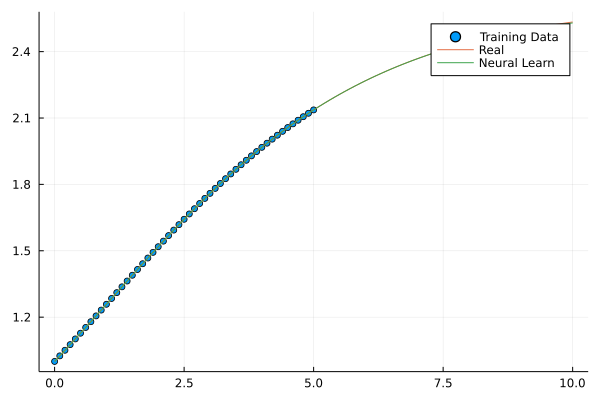

In [3]:
ann_model = FastChain(FastDense(1, 32,tanh),FastDense(32, 32,tanh),FastDense(32, 1))
p = Float64.(initial_params(ann_model))
function train(θ)
    ann_model(data_solve.t',θ)
end
#println(train(p))
function loss(θ)
    pred = train(θ)
    sum(abs2, (data .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
#println(loss(p))
const losses = []
callback(θ,l,pred) = begin
    push!(losses, l)
    if length(losses)%50==0
        println(losses[end])
    end
    false
end
res1_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.02), cb=callback, maxiters = 500)
res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 2000)
scatter(data_solve.t, data[1,:],label = "Training Data")
plot!(test_data.t, data_real[1,:], label="Real")
data_learn = ann_model(test_data.t',res2_node.minimizer)'
plot!(test_data.t,data_learn,label="Neural Learn")

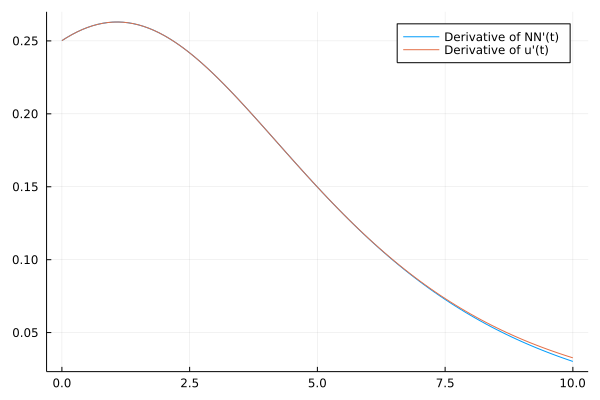

In [4]:
using Zygote
f(t) = ann_model(t, res2_node.minimizer)[1]
g(t) = f'(t)[1]
plot(test_data.t,g.(test_data.t),label = "Derivative of NN'(t)")
f1(xx)=0.2*xx*exp(-0.2*xx)*(1-xx/2)+0.2*sin(xx)
f1.(data_real)
plot!(test_data.t, f1.(data_real)',label = "Derivative of u'(t)")

# 1.2. Using RNN or GRU or LSTM to Learn


In [5]:
rnn = Chain(RNN(1,1),Dense(1,32,relu),Dense(32,1))
gru = Chain(GRU(1,1),Dense(1,32,relu),Dense(32,1))
lstm =Chain(LSTM(1,1),Dense(1,32,relu),Dense(32,1))
tspan_train = Float32.(data_solve.t)
#println(rnn(Float32.([1 2])))
#rnn(tspan_train')
#gru(tspan_train')
#lstm(tspan_train')
#p,θ = Flux.destructure(LSTM(1,1))
#params(LSTM(1,1))

loss_rnn(a,b) = Flux.Losses.mse(rnn(a),b)
loss_gru(a,b) = Flux.Losses.mse(gru(a),b)
loss_lstm(a,b) = Flux.Losses.mse(lstm(a),b)
opt = ADAM(0.02)
train!(loss_rnn, params(rnn), [(tspan_train',data)], opt)
train!(loss_gru, params(gru), [(tspan_train',data)], opt)
train!(loss_lstm, params(lstm), [(tspan_train',data)], opt)
println(loss_rnn(tspan_train', data))
for epoch in 1:10000
    train!(loss_rnn, params(rnn), [(tspan_train',data)], opt)
    train!(loss_gru, params(gru), [(tspan_train',data)], opt)
    train!(loss_lstm, params(lstm), [(tspan_train',data)], opt)
end
println(loss_rnn(tspan_train', data))
println(loss_gru(tspan_train', data))
println(loss_lstm(tspan_train', data))




2.422489698021464


7.577315600884444e-7


2.581296307590706e-6


4.709784754958914e-6


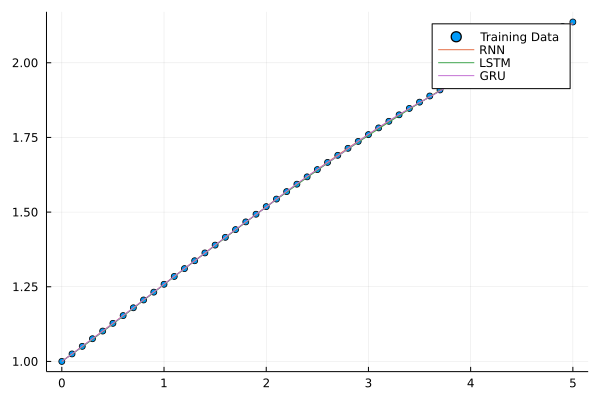

In [6]:

scatter(data_solve.t, data[1,:],label = "Training Data")
#plot!(test_data.t, data_real[1,:], label="Real")
data_learn_rnn = rnn(tspan_train')
data_learn_gru = gru(tspan_train')
data_learn_lstm = lstm(tspan_train')
plot!(data_solve.t,data_learn_rnn',label="RNN")
plot!(data_solve.t,data_learn_lstm',label="LSTM")
plot!(data_solve.t,data_learn_gru',label="GRU")

In [7]:
"""
rnn = Chain(RNN(1,1),Dense(1,32,relu),Dense(32,1))
gru = Chain(GRU(1,1),Dense(1,32,relu),Dense(32,1))
lstm =Chain(LSTM(1,1),Dense(1,32,relu),Dense(32,1))
tspan_train = Float32.(data_solve.t)
p_rnn, re_rnn =Flux.destructure(rnn)
p_lstm, re_lstm =Flux.destructure(lstm)
p_gru, re_gru =Flux.destructure(gru)
println(re_rnn(p_rnn)(tspan_train'))
function train_rnn(θ)
    re_rnn(θ)(tspan_train')
end
function train_gru(θ)
    re_gru(θ)(tspan_train')
end
function train_lstm(θ)
    re_lstm(θ)(tspan_train')
end

function loss_rnn(θ)
    pred = train_rnn(θ)
    sum(abs2, (Float32.(data) .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
function loss_lstm(θ)
    pred = train_lstm(θ)
    sum(abs2, (Float32.(data) .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
function loss_gru(θ)
    pred = train_gru(θ)
    sum(abs2, (Float32.(data) .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
println(loss_rnn(p_rnn))
println(loss_gru(p_gru))
println(loss_lstm(p_lstm))
const losses = []
callback(θ,l,pred) = begin
    push!(losses, l)
    if length(losses)%50==0
        println(losses[end])
    end
    false
end
res1_rnn = DiffEqFlux.sciml_train(loss_rnn, p_rnn, ADAM(0.02), cb=callback, maxiters = 500)
res2_rnn = DiffEqFlux.sciml_train(loss_rnn, res1_rnn.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 2000)
"""


"rnn = Chain(RNN(1,1),Dense(1,32,relu),Dense(32,1))\ngru = Chain(GRU(1,1),Dense(1,32,relu),Dense(32,1))\nlstm =Chain(LSTM(1,1),Dense(1,32,relu),Dense(32,1))\ntspan_train = Float32.(data_solve.t)\np_rnn, re_rnn =Flux.destructure(rnn)\np_lstm, re_lstm =Flux.destructure(lstm)\np_gru, re_gru =Flux.destructure(gru)\nprintln(re_rnn(p_rnn)(tspan_train'))\nfunction train_rnn(θ)\n    re_rnn(θ)(tspan_train')\nend\nfunction train_gru(θ)\n    re_gru(θ)(tspan_train')\nend\nfunction train_lstm(θ)\n    re_lstm(θ)(tspan_train')\nend\n\nfunction loss_rnn(θ)\n    pred = train_rnn(θ)\n    sum(abs2, (Float32.(data) .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))\nend\nfunction loss_lstm(θ)\n    pred = train_lstm(θ)\n    sum(abs2, (Float32.(data) .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))\nend\nfunction loss_gru(θ)\n    pred = train_gru(θ)\n    sum(abs2, (Float32.(data) .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))\nend\nprintln(loss_rnn(p_rnn))\nprintln(loss_gru(p_gru))\nprintln(loss

## 1.3. Use Neural Differential Equation

0.1500100469730486


0.06975021881145764


0.04174457487594822


0.02358834870607589


0.013206320874584655


0.008107576522271601


0.005933176255228279


0.005118948646511413


0.004846320645362304


0.004760293742284362


8.043427293757701e-6


7.992509836779103e-7


6.394312797322251e-9


5.48617801915062e-9


4.763550819877632e-9


4.348277354208386e-9


4.119258734834851e-9


3.96977844441956e-9


3.826178308638366e-9


3.6737692448292208e-9


3.4686411720954546e-9


3.268807837666179e-9


3.131236451071039e-9


3.0596858570114043e-9


2.9912848848052757e-9


2.90914455743605e-9


2.794679846271066e-9


2.652151817090828e-9


2.4810560434456625e-9


2.277659406361866e-9


2.115437621535835e-9


1.98113264031653e-9


1.8533375432969671e-9


1.740655619364793e-9


1.5775252692313257e-9


1.2440456974124092e-9


7.292402189792206e-10


4.1921115087397634e-10


3.982343812260593e-10


3.8394110112781564e-10


3.7349772090564234e-10


3.611505365329504e-10


3.4879447012731287e-10


3.3256989401954434e-10


3.121187237918012e-10


2.9728142613706746e-10


2.7917572184977864e-10


2.635309158461206e-10


2.4913787134710907e-10


2.3338773732307704e-10


[-0.39795089539638445, 0.13951462139798462, 0.16634638281287376, 0.14770220503439635, -0.042780454745886605, 0.14037665064180438, 0.4955901739708158, 0.07076488738673925, 0.1872073552215574, 0.17487983488367298, -0.1683278691626696, -0.15288999795904648, 0.3411292205156596, 0.17181666985219055, 0.5427024891833678, -0.15804899191363755, 0.1313338305716255, 0.15506130458398934, -0.15571918457045983, -0.1941979149609249, -0.1867593146847704, -0.15266905920982918, 0.19828811604503732, 0.45781305060866395, -0.06790577801364467, -0.12663030479083898, -0.6538161491882947, -0.033820554102226716, -0.4986849073478676, 0.13342182432184818, 0.41083237547793794, 0.3467535853604076, 0.06018399679239673, -0.234808619137552, -0.25236020955922694, -0.07085208608712237, 0.013212066059273102, 0.008531639961399334, 0.08880039810216693, 0.31516575748026837, -0.184178336823463, -0.053052745865840155, 0.24809598097018892, 0.11806519490307768, -0.3788361513783015, -0.010774134277145953, 0.058427438110764396, 

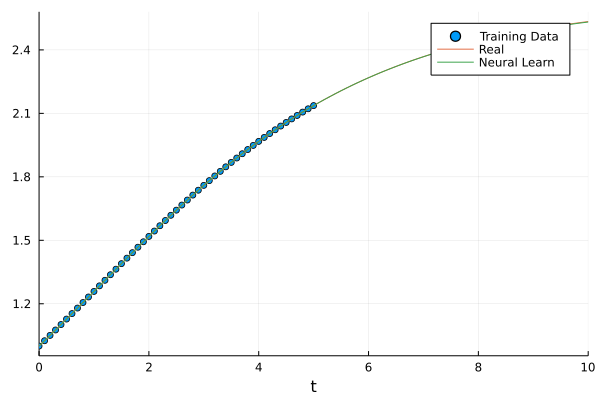

In [8]:
ann_node = FastChain(FastDense(1, 32,tanh),FastDense(32, 1))
p = Float64.(initial_params(ann_node))
function model2_nn(du,u,p,t)
    du[1] =  ann_node(u,p)[1]
end
prob_nn = ODEProblem(model2_nn, u_0, tspan_data, p)
function train(θ)
    Array(concrete_solve(prob_nn, Tsit5(), u_0, θ, saveat = 0.1,
                         abstol=1e-6, reltol=1e-6))#,sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end
#println(train(p))
function loss(θ)
    pred = train(θ)
    sum(abs2, (data .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
#println(loss(p))
const losses = []
callback(θ,l,pred) = begin
    push!(losses, l)
    if length(losses)%50==0
        println(losses[end])
    end
    false
end
res1_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.02), cb=callback, maxiters = 500)
res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 2000)
println(res2_node.minimizer)
scatter(data_solve.t, data[1,:],label = "Training Data")
plot!(test_data, label="Real")

prob_nn2 = ODEProblem(model2_nn, u_0, tspan_predict, res2_node.minimizer)
s_nn = solve(prob_nn2, Tsit5(), saveat = 0.1)
plot!(s_nn,label="Neural Learn")

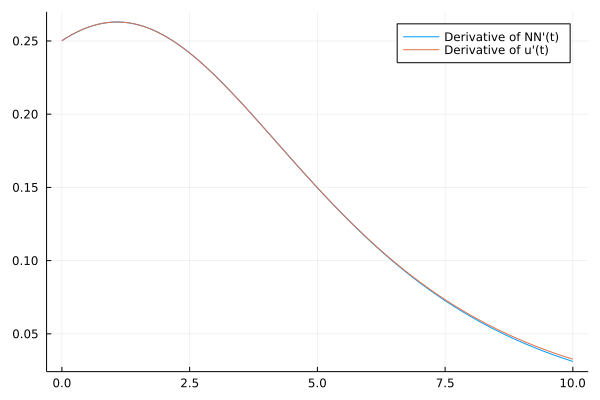

In [9]:
f(x) = ann_node(x, res2_node.minimizer)[1]
plot(test_data.t,f.(data_real)',label = "Derivative of NN'(t)")
f1(xx)=0.2*xx*exp(-0.2*xx)*(1-xx/2)+0.2*sin(xx)
f1.(data_real)
plot!(test_data.t, f1.(data_real)',label = "Derivative of u'(t)")

# 2. Complicated Model

In this part, I will test
$$ \begin{aligned}
& \frac{\rm{d}S}{\rm{dt}} = -\beta S \exp(-\alpha I) I^k,\\
&\frac{\rm{d}I}{\rm{dt}} = \beta S\exp(-\alpha I) I^k- \gamma I
\end{aligned}$$
to generate data with noise.

## Data generation

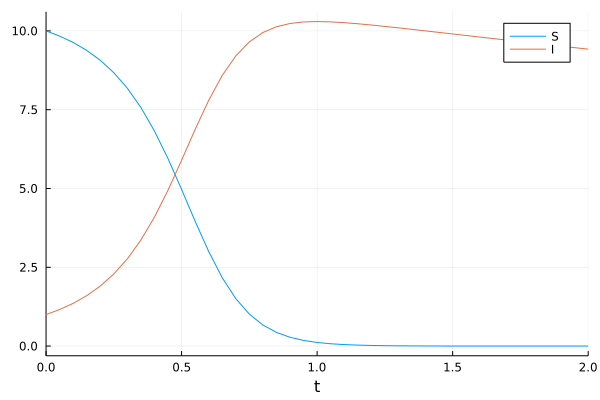

In [10]:
function SIR(du,u,p,t)
    β, γ, α, k = p
   S, I = u
   du[1] = - β*S*exp(-α*I)*I^k
   du[2] = β*S*exp(-α*I)*I^k - γ*I
end
u_0 = [10, 1]
p_data = [0.3,0.1,0.01,1.5]
tspan_data = (0.0, 1.0)
prob_data = ODEProblem(SIR,u_0,tspan_data,p_data)
data_solve = solve(prob_data, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.05)
data_withoutnois = Array(data_solve)
data = data_withoutnois #+ Float32(2e-1)*randn(eltype(data_withoutnois), size(data_withoutnois))
tspan_predict = (0.0, 2.0)
prob_predict = ODEProblem(SIR,u_0,tspan_predict,p_data)
test_data = solve(prob_predict, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.05)
data_real = Array(test_data)
plot(test_data, label = ["S" "I"])

## 2.1. Using NN(t) to learn

0.4670272923765777
0.18805178304668926
0.1075832225868422
0.04957264523763713


0.02397069156578316


1.5370117509618474e-5


3.478192254799265e-6


7.253922787883859e-7


1.4488944229455656e-7


8.545982268565443e-8


5.513062039791121e-8


3.5280363169003516e-8


2.095172992329406e-8


1.7760577887571776e-8


8.753637042377502e-9


6.079437545290508e-9


5.943222829706713e-9


4.374033113214212e-9


3.7303410823525315e-9


3.4200420645210663e-9


3.3912775219211696e-9


3.2247158844898783e-9


2.3016709555636783e-9


2.0670331491685534e-9


1.8570366956910237e-9


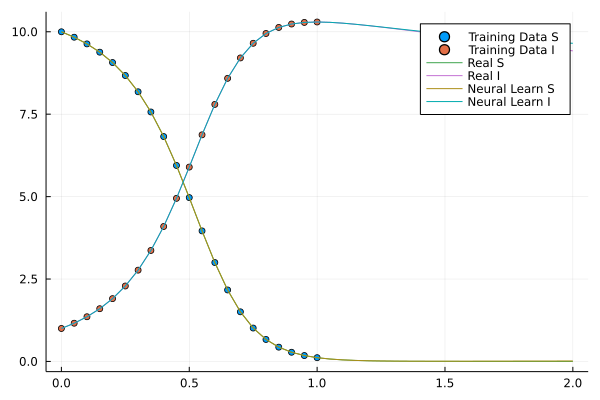

In [11]:
ann_model = FastChain(FastDense(1, 32,tanh),FastDense(32, 32,tanh),FastDense(32, 2))
p = Float64.(initial_params(ann_model))
function train(θ)
    ann_model(data_solve.t',θ)
end
#println(train(p))
function loss(θ)
    pred = train(θ)
    sum(abs2, (data .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
#println(loss(p))
const losses = []
callback(θ,l,pred) = begin
    push!(losses, l)
    if length(losses)%100==0
        println(losses[end])
    end
    false
end
res1_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.02), cb=callback, maxiters = 500)
res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 2000)
scatter(data_solve.t, data[1,:],label = "Training Data S")
scatter!(data_solve.t, data[2,:],label = "Training Data I")
plot!(test_data.t, data_real[1,:], label="Real S")
plot!(test_data.t, data_real[2,:], label="Real I")
data_learn = ann_model(test_data.t',res2_node.minimizer)'
plot!(test_data.t,data_learn[1,:],label="Neural Learn S")
plot!(test_data.t,data_learn[2,:],label="Neural Learn I")
data_learn = ann_model(test_data.t',res2_node.minimizer)'
scatter(data_solve.t, data[1,:],label = "Training Data S")
scatter!(data_solve.t, data[2,:],label = "Training Data I")
plot!(test_data.t, data_real[1,:], label="Real S")
plot!(test_data.t, data_real[2,:], label="Real I")
plot!(test_data.t, data_learn,label=["Neural Learn S" "Neural Learn I"])
#plot!(test_data.t,data_learn[2,:],label="Neural Learn I")

## 2.2. Use RNN or LSTM or GRU


In [12]:
rnn = Chain(RNN(1,2),Dense(2,32,relu),Dense(32,2))
gru = Chain(GRU(1,2),Dense(2,32,relu),Dense(32,2))
lstm =Chain(LSTM(1,2),Dense(2,32,relu),Dense(32,2))
tspan_train = Float32.(data_solve.t)
#println(rnn(Float32.([1 2])))
#rnn(tspan_train')
#gru(tspan_train')
#lstm(tspan_train')
#p,θ = Flux.destructure(LSTM(1,1))
#params(LSTM(1,1))

loss_rnn(a,b) = Flux.Losses.mse(rnn(a),b)
loss_gru(a,b) = Flux.Losses.mse(gru(a),b)
loss_lstm(a,b) = Flux.Losses.mse(lstm(a),b)
opt = ADAM(0.05)
train!(loss_rnn, params(rnn), [(tspan_train',data)], opt)
train!(loss_gru, params(gru), [(tspan_train',data)], opt)
train!(loss_lstm, params(lstm), [(tspan_train',data)], opt)
println(loss_rnn(tspan_train', data))
for epoch in 1:20000
    train!(loss_rnn, params(rnn), [(tspan_train',data)], opt)
    train!(loss_gru, params(gru), [(tspan_train',data)], opt)
    train!(loss_lstm, params(lstm), [(tspan_train',data)], opt)
end
println(loss_rnn(tspan_train', data))
println(loss_gru(tspan_train', data))
println(loss_lstm(tspan_train', data))

39.36848552850429
0.00040344864489962
0.0006824985100117302
1.5138768475934549e-5


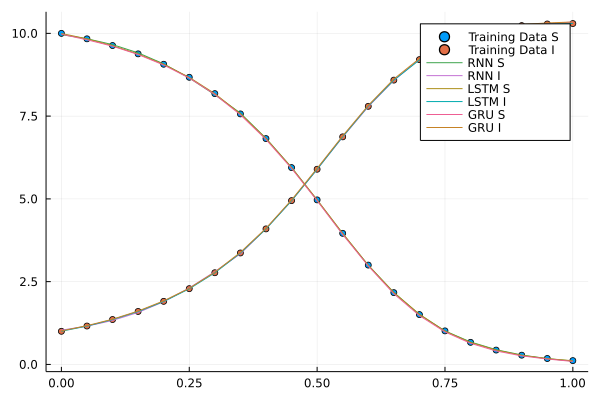

In [13]:
scatter(data_solve.t, data[1,:],label = "Training Data S")
scatter!(data_solve.t, data[2,:],label = "Training Data I")
#plot!(test_data.t, data_real[1,:], label="Real")
data_learn_rnn = rnn(tspan_train')
data_learn_gru = gru(tspan_train')
data_learn_lstm = lstm(tspan_train')
plot!(data_solve.t,data_learn_rnn',label=["RNN S" "RNN I"] )
plot!(data_solve.t,data_learn_lstm',label=["LSTM S" "LSTM I"])
plot!(data_solve.t,data_learn_gru',label=["GRU S" "GRU I"])

## 2.3. Use neural differential equation
use the following universal differential equation to learn the model.
$$ \begin{aligned}
& \frac{\rm{d}S}{\rm{dt}} = - NN(I) S,\\
&\frac{\rm{d}I}{\rm{dt}} = NN(I) S- \gamma I,
\end{aligned}.$$
where $NN$ is a deep neural network.  

86.56948535649276


44.26587222618158


9.87422610839863


2.8790972304462015


2.4190885481991193


2.247937305690006


2.091229297522048


1.9454308920871906


1.8092899327847767


1.6821473811198877


0.01487150232515366


0.0003370623171866908


1.068882847418577e-5


8.130307370558112e-6


4.233446853539012e-6


1.4523721052994649e-6


4.4284581291382385e-7


3.340031534036121e-7


3.1569433616999406e-7


2.5788627102952594e-7


2.1500679251877616e-7


1.8783263125759704e-7


1.677364765583952e-7


1.5173894507853728e-7


1.4145261536365954e-7


1.3707689855215606e-7


1.3638823973443128e-7


1.3351497989310902e-7


1.2053258454843235e-7


1.1214922587860755e-7

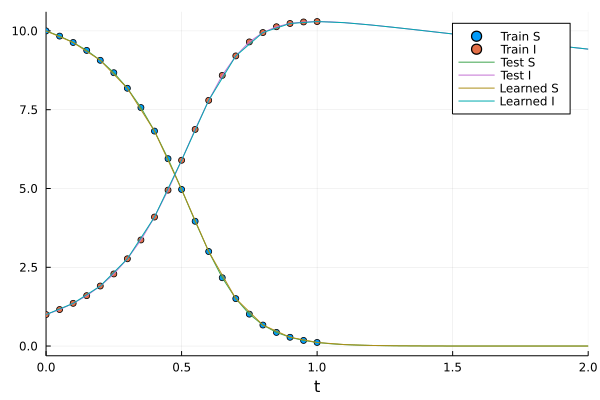

In [14]:
ann_node = FastChain(FastDense(1, 32, tanh),FastDense(32, 1))
p = Float64.(initial_params(ann_node))
p_know = 0.1
function SIR_nn(du,u,p,t)
   γ = p_know
   S, I = u
   du[1] =  - S*ann_node(I,p)[1]
   du[2] = S*ann_node(I,p)[1] - γ*I
   [du[1],du[2]]
end
prob_nn = ODEProblem(SIR_nn, u_0, tspan_data, p)
function train(θ)
   Array(concrete_solve(prob_nn, Vern7(), u_0, θ, saveat = 0.05,
                        abstol=1e-6, reltol=1e-6,
                        sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end
function loss(θ)
   pred = train(θ)
   sum(abs2, (data .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
#println(loss(p))
const losses = []
callback(θ,l,pred) = begin
   push!(losses, l)
   if length(losses)%50==0
       println(losses[end])
   end
   false
end
res1_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 500)
res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 1000)
scatter(data_solve.t, data[1,:],label = "Train S")
scatter!(data_solve.t, data[2,:],label = "Train I")
plot!(test_data, label=["Test S" "Test I"])


prob_nn2 = ODEProblem(SIR_nn, u_0, tspan_predict, res2_node.minimizer)
s_nn = solve(prob_nn2, Tsit5(), saveat = 0.1)
plot!(s_nn,label=["Learned S" "Learned I"])

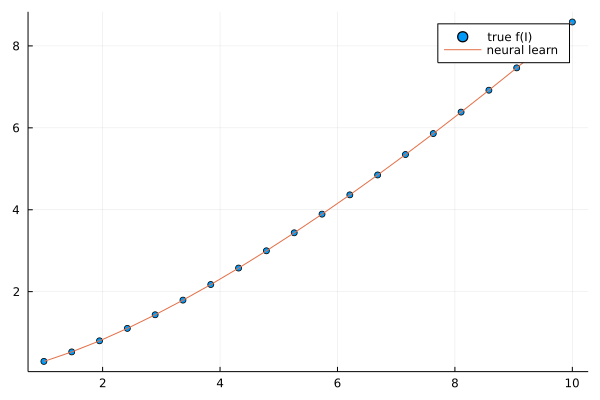

In [15]:
x=range(1.0,10,length=20)
#y=range(1.0,10,length=10)
f(x) = 0.3*exp(-0.01*x)*x^1.5
g(x) = ann_node(x,res2_node.minimizer)[1]

scatter(x,f.(x), label = "true f(I)")
plot!(x,g.(x),label = "neural learn")

# Summary

For simple model(low dimensional) with good quality data (without noise, derivatives can be obtained), NN, RNN&LSTM&GRU, Neural differential equation are all good ways.

While training, I find that RNN LSTM GRU tend to unstable. GRU is much better, LSTM not stable.


# Learn $sin(t)$
$$ u' = v, v' = -u$$
Here we know that $u= sin(t)$

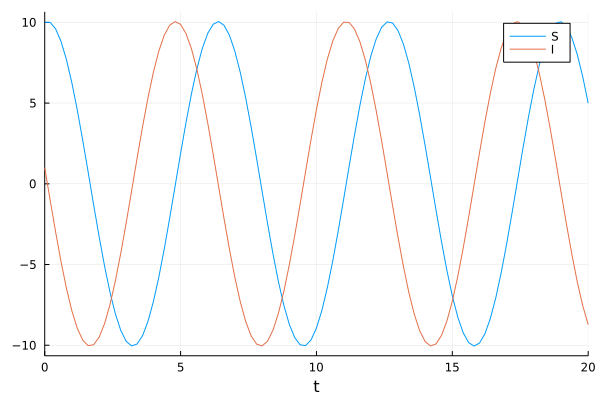

In [16]:
function SIR(du,u,p,t)
   S, I = u
   du[1] =  p[1]*I
   du[2] = -p[2]*S
end
u_0 = [10, 1]
p_data = [1,1]
tspan_data = (0.0, 10)
prob_data = ODEProblem(SIR,u_0,tspan_data,p_data)
data_solve = solve(prob_data, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.2)
data_withoutnois = Array(data_solve)
data = data_withoutnois #+ Float32(2e-1)*randn(eltype(data_withoutnois), size(data_withoutnois))
tspan_predict = (0.0, 20)
prob_predict = ODEProblem(SIR,u_0,tspan_predict,p_data)
test_data = solve(prob_predict, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.2)
data_real = Array(test_data)
plot(test_data, label = ["S" "I"])

# 3.1. using NN(t) (Failure)

[0.0 0.02858557604141919 0.05750197496967035 0.0863405032324162 0.11468734752559777 0.14214922682508144 0.1683762324634948 0.19307907190490248 0.21603924133006164 0.237112039120802 0.256223428070926 0.2733623801626556 0.2885705017312235 0.30193056114182115 0.31355518134313654 0.32357654885197923 0.3321376162726787 0.33938498001224293 0.34546340829547745 0.3505118677809962 0.35466083280246485 0.3580306411183602 0.3607306680383188 0.36285911454576536 0.3645032358401146 0.36573986892556903 0.3666361481476396 0.36725032422249687 0.3676326246838224 0.3678261117994578 0.36786750825218184 0.36778797176337347 0.3676138079354129 0.3673671164433953 0.36706636980405355 0.3667269267017578 0.36636148359626663 0.3659804693446622 0.36559238805166294 0.3652041154797373 0.36482115422449096 0.3644478525810844 0.3640875916585584 0.36374294488655234 0.36341581363431963 0.36310754224598674 0.3628190154017134 0.3625507403493659 0.36230291621925403 0.3620754923364264 0.3618682171803888; 0.0 0.034128034219405

 0.3492548904789497 0.3654309698811003 0.38082031640511665 0.3954641341541235 0.40939692621640755 0.42264817326571574 0.4352437850558334 0.4472072817301303 0.45856070371270236 0.4693252737828688 0.4795218473625184 0.4891711910934054 0.49829412862629285 0.506911588508031 0.5150445837242367 0.5227141468481692 0.5299412394558026 0.536746649799668 0.5431508888087365 0.5491740913031204 0.5548359268216866 0.5601555225686349 0.5651513995931481 0.569841422328754 0.5742427609497301 0.578371865576453 0.5822444511183861 0.5858754914326488 0.5892792214584899 0.5924691460333095 0.5954580541811789 0.598258037773255 0.6008805135788714 0.6033362478478698 0.6056353826831853 0.6077874635741286 0.6098014675630564]


367.4036782250838
62.43610452457624


25.249502012200175
14.465438870773214
9.722414500383914


0.21376108690486292


0.04076546672910539


0.015459667539185972


0.0065108178169919415


0.004669918501567933


0.002828736842291297


0.0019794780858224635


0.0015739614413308504


0.0009933299197674157


0.0007018206723854283


0.000517886087346203


0.0004047056147123843


0.0003315064494493325


0.0003174195362989975


0.00030109937018220524


0.00021503399439103775


0.00013223550845412488


9.553456132062381e-5


8.27075382546472e-5


6.619438991253883e-5


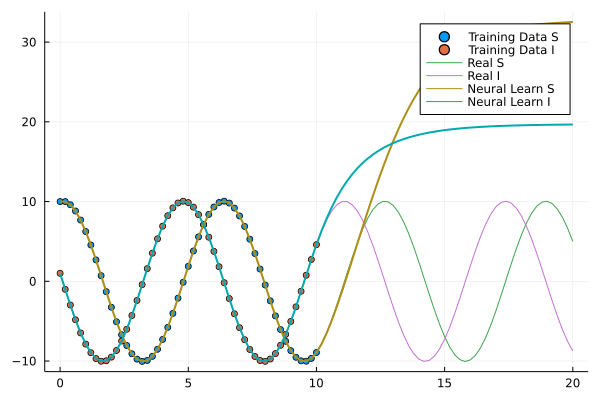

In [17]:
ann_model = FastChain(FastDense(1, 32,tanh),FastDense(32, 32,swish),FastDense(32, 2))
p = Float64.(initial_params(ann_model))
function train(θ)
    ann_model(data_solve.t',θ)
end
println(train(p))
function loss(θ)
    pred = train(θ)
    sum(abs2, (data .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
#println(loss(p))
const losses = []
callback(θ,l,pred) = begin
    push!(losses, l)
    if length(losses)%100==0
        println(losses[end])
    end
    false
end
res1_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.02), cb=callback, maxiters = 500)
res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 2000)
scatter(data_solve.t, data[1,:],label = "Training Data S")
scatter!(data_solve.t, data[2,:],label = "Training Data I")
plot!(test_data.t, data_real[1,:], label="Real S")
plot!(test_data.t, data_real[2,:], label="Real I")
data_learn = ann_model(test_data.t',res2_node.minimizer)'
plot!(test_data.t,data_learn[1,:],label="Neural Learn S")
plot!(test_data.t,data_learn[2,:],label="Neural Learn I")
data_learn = ann_model(test_data.t',res2_node.minimizer)'
scatter(data_solve.t, data[1,:],label = "Training Data S")
scatter!(data_solve.t, data[2,:],label = "Training Data I")
plot!(test_data.t, data_real[1,:], label="Real S")
plot!(test_data.t, data_real[2,:], label="Real I")
plot!(test_data.t, data_learn,label=["Neural Learn S" "Neural Learn I"], lw =2)
#plot!(test_data.t,data_learn[2,:],label="Neural Learn I")

# 3.2. using RNN & LSTM & GRU (Failed)

48.72322583372141


5.9099712760189425
0.01523551790381247
0.13741198334926508


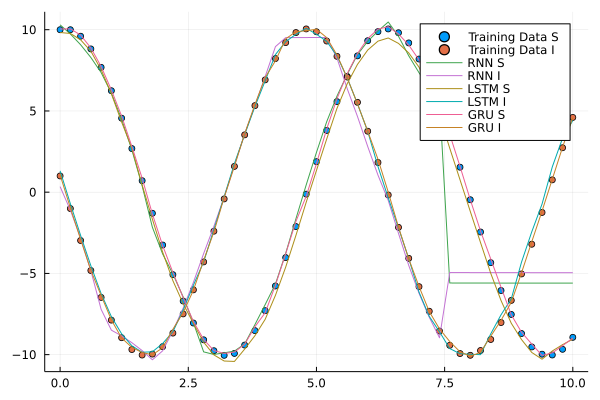

In [18]:
rnn = Chain(RNN(1,2),Dense(2,32,relu),Dense(32,2))
gru = Chain(GRU(1,2),Dense(2,32,relu),Dense(32,2))
lstm =Chain(LSTM(1,2),Dense(2,32,relu),Dense(32,2))
tspan_train = Float32.(data_solve.t)
#println(rnn(Float32.([1 2])))
#rnn(tspan_train')
#gru(tspan_train')
#lstm(tspan_train')
#p,θ = Flux.destructure(LSTM(1,1))
#params(LSTM(1,1))

loss_rnn(a,b) = Flux.Losses.mse(rnn(a),b)
loss_gru(a,b) = Flux.Losses.mse(gru(a),b)
loss_lstm(a,b) = Flux.Losses.mse(lstm(a),b)
opt = ADAM(0.1)
train!(loss_rnn, params(rnn), [(tspan_train',data)], opt)
train!(loss_gru, params(gru), [(tspan_train',data)], opt)
train!(loss_lstm, params(lstm), [(tspan_train',data)], opt)
println(loss_rnn(tspan_train', data))
for epoch in 1:20000
    train!(loss_rnn, params(rnn), [(tspan_train',data)], opt)
    train!(loss_gru, params(gru), [(tspan_train',data)], opt)
    train!(loss_lstm, params(lstm), [(tspan_train',data)], opt)
end
println(loss_rnn(tspan_train', data))
println(loss_gru(tspan_train', data))
println(loss_lstm(tspan_train', data))
scatter(data_solve.t, data[1,:],label = "Training Data S")
scatter!(data_solve.t, data[2,:],label = "Training Data I")
#plot!(test_data.t, data_real[1,:], label="Real")
data_learn_rnn = rnn(tspan_train')
data_learn_gru = gru(tspan_train')
data_learn_lstm = lstm(tspan_train')
plot!(data_solve.t,data_learn_rnn',label=["RNN S" "RNN I"] )
plot!(data_solve.t,data_learn_lstm',label=["LSTM S" "LSTM I"])
plot!(data_solve.t,data_learn_gru',label=["GRU S" "GRU I"])

# 2.3. Neural Differential Equation


5679.290505092073


5619.51576510046


5616.455610021433


5613.26319494789


5609.62001792227


5605.5675749249185


5601.138795180676


5596.359998501025


5591.25320681873


5585.837519106266

┌ Warning: Instability detected. Aborting
└ @ SciMLBase F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\SciMLBase\h4Gxc\src\integrator_interface.jl:351


┌ Warning: Instability detected. Aborting
└ @ SciMLBase F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\SciMLBase\h4Gxc\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\SciMLBase\h4Gxc\src\integrator_interface.jl:351


0.017256618122906235

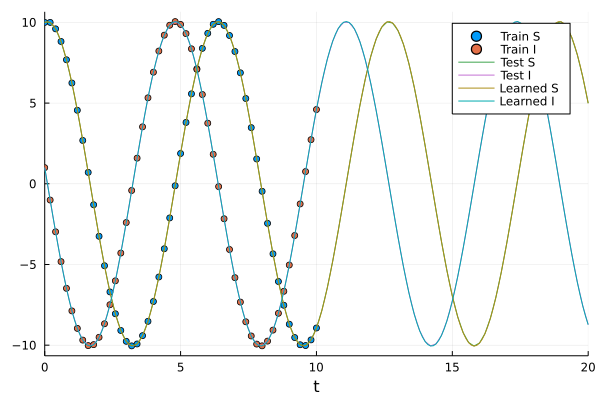

In [19]:
ann_node = FastChain(FastDense(2, 16),FastDense(16, 2))
p = Float64.(initial_params(ann_node))
p_know = 0.1
function SIR_nn(du,u,p,t)
   S, I = u
   du[1] =  ann_node([S,I],p)[1]
   du[2] = ann_node([S,I],p)[2]
   [du[1],du[2]]
end
prob_nn = ODEProblem(SIR_nn, u_0, tspan_data, p)
function train(θ)
   Array(concrete_solve(prob_nn, Vern7(), u_0, θ, saveat = 0.2,
                        abstol=1e-6, reltol=1e-6,
                        sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end
function loss(θ)
   pred = train(θ)
   sum(abs2, (data .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
#println(loss(p))
const losses = []
callback(θ,l,pred) = begin
   push!(losses, l)
   if length(losses)%50==0
       println(losses[end])
   end
   false
end
res1_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 500)
res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 1000)
scatter(data_solve.t, data[1,:],label = "Train S")
scatter!(data_solve.t, data[2,:],label = "Train I")
plot!(test_data, label=["Test S" "Test I"])


prob_nn2 = ODEProblem(SIR_nn, u_0, tspan_predict, res2_node.minimizer)
s_nn = solve(prob_nn2, Tsit5(), saveat = 0.1)
plot!(s_nn,label=["Learned S" "Learned I"])